In [1]:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    import numpy as np
from TDD.TDD import Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx

In [2]:
def simulate(cir,ini=False):
    tn,all_indexs = cir_2_tn(cir)
    tn.tensors=[ts for ts in tn.tensors if ts.name!='nu_q']
#     A=[ts.name for ts in tn.tensors]
#     print(A)
    if ini:
        var=[]
        for idx in all_indexs:
            if idx[0]=='x' and not '_' in idx:
                var.append('a'+idx[1:])
            var.append(idx)
            if idx[0]=='y' and not '_' in idx:
                var.append('b'+idx[1:])
#         print(var)
        for n in range(10):
            for k in range(50):
                s ='x'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)
                s ='y'+str(n)+'_'+str(k)
                if not s in var:
                    var.append(s)               
                
        
        Ini_TDD(index_order=var)
        set_root_of_unit(2**3)

#     t_start=time.time()
    tdd=tn.cont()
#     print(time.time()-t_start)
#     print(tdd.weight)
#     print(tdd.node_number())
    return tdd

def change_index(tdd,x,y):
    """change the index from x to y"""
    
    idx_set = []
    key_2_index  = dict()
    index_2_key = dict()
    
    for idx in tdd.index_set:
        if idx.key[0]==x:
            idx_set.append(Index(y+idx.key[1:],idx.idx))
        else:
            idx_set.append(idx)
    
    for k in tdd.key_2_index:
        if isinstance(tdd.key_2_index[k],str) and tdd.key_2_index[k][0]==x:
            key_2_index[k]=y+tdd.key_2_index[k][1:]
        else:
            key_2_index[k]=tdd.key_2_index[k]
            
    for k in tdd.index_2_key:
        if isinstance(k,str) and k[0]==x:
            index_2_key[y+k[1:]]=tdd.index_2_key[k]
        else:
            index_2_key[k]=tdd.index_2_key[k]
    tdd.index_set=idx_set
    tdd.key_2_index=key_2_index
    tdd.index_2_key = index_2_key
    
    
def update_tdd(tdd,cir_head,cir_end):
#     cir_head.x([0,1,2])
#     cir_head.x([0,1,2])
#     cir_end.x([0,1,2])
#     cir_end.x([0,1,2])
    tdd1 = simulate(cir_head)
    change_index(tdd1,'x','a')
    change_index(tdd1,'y','x')

    tdd2 = simulate(cir_end)
    change_index(tdd2,'y','b')
    change_index(tdd2,'x','y')
    
    tdd_new=cont(tdd1,tdd)
    tdd_new=cont(tdd_new,tdd2)

    change_index(tdd_new,'a','x')
    change_index(tdd_new,'b','y')
    # tdd_new=renormalize(tdd_new)
    return tdd_new

def eliminate_control2(tdd,mode='x',level=0):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    if mode=='x':
        x=tdd.node.key-2*level
        the_map = get_downward_k_level_map(tdd,level,0)
    else:
        x=tdd.node.successor[0].key-2*level
        the_map = get_downward_k_level_map(tdd,level,1)
    
    q_c = int(tdd.key_2_index[x][1:])

    flag = False
    if the_map.level==-1:
        return tdd.self_copy(),cir_head,cir_end
    
    while the_map.level>-1:
        if x%2!=the_map.level%2:
            the_map=the_map.father
        else:
            flag = True
            temp_map=the_map
            the_map=the_map.father

    if flag == False:
        return tdd.self_copy(),cir_head,cir_end
    
    q = int(tdd.key_2_index[temp_map.level][1:])

    if tdd.key_2_index[temp_map.level][0]=='x':
        if temp_map.rotate>0:
            cir_head.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
        if temp_map.x==1:
            cir_head.cx(q_c,q)
    else:
        if temp_map.x==1:
            cir_end.cx(q_c,q)
        if temp_map.rotate>0:
            cir_end.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
    # print(cir_head.qasm())
    # print(cir_end.qasm())
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new2,cir_head2,cir_end2 = eliminate_control2(tdd_new,mode,level)
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2
    
def eliminate_top_control2(tdd,level=0):
    tdd_new,cir_head,cir_end = eliminate_control2(tdd,'x',level)
    
    tdd_new2,cir_head2,cir_end2 = eliminate_control2(tdd_new,'y',level)
    

    if tdd_new2.map.level>-1:
        tdd_new3,cir_head3,cir_end3=eliminate_global_map(tdd_new2)
        return tdd_new3,cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3
    
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2


def eliminate_top_partial_control2(tdd,level=0):

    # print(tdd.map)
    # print(tdd.node.out_maps[1])
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    the_map = get_downward_k_level_map(tdd,level,0)
    if the_map.father.level==-1:
        the_map = get_downward_k_level_map(tdd,level,1)
    else:
        the_map = the_map.father
    
    q_c = level
    
    if the_map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    while the_map.level>-1:
        temp_map=the_map
        the_map=the_map.father
    
    q = int(tdd.key_2_index[temp_map.level][1:])

    if tdd.key_2_index[temp_map.level][0]=='x':
        if temp_map.rotate>0:
            cir_head.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
        if temp_map.x==1:
            cir_head.cx(q_c,q)
    else:
        if temp_map.x==1:
            cir_end.cx(q_c,q)
        if temp_map.rotate>0:
            cir_end.cp(np.pi/4*(8-temp_map.rotate),q_c,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)

    if tdd_new == tdd:
        return tdd.self_copy(),cir_head,cir_end
    
    tdd_new2,cir_head2,cir_end2 = eliminate_top_partial_control2(tdd_new,level)
    
    if tdd_new2.map.level>-1:
        tdd_new3,cir_head3,cir_end3=eliminate_global_map(tdd_new2)
        return tdd_new3,cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2

def eliminate_top_partial_control3(tdd,level=0):

    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)

    the_map1 = get_downward_k_level_map(tdd,level,0)
    the_map2 = get_downward_k_level_map(tdd,level,1)


    
    if the_map.father.level==-1:
        the_map = get_downward_k_level_map(tdd,level,1)
    else:
        the_map = the_map.father
    
    q_c = level
    
    if the_map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    while the_map.level>-1:
        temp_map=the_map
        the_map=the_map.father
    
    q = int(tdd.key_2_index[temp_map.level][1:])

    if tdd.key_2_index[temp_map.level][0]=='x':
        if temp_map.rotate>0:
            cir_head.cp(np.pi/4*(8-temp_map.rotate),q_c,q)
        if temp_map.x==1:
            cir_head.cx(q_c,q)
    else:
        if temp_map.x==1:
            cir_end.cx(q_c,q)
        if temp_map.rotate>0:
            cir_end.cp(np.pi/4*(8-temp_map.rotate),q_c,q)

    tdd_new = update_tdd(tdd,cir_head,cir_end)

    if tdd_new == tdd:
        return tdd.self_copy(),cir_head,cir_end
    
    tdd_new2,cir_head2,cir_end2 = eliminate_top_partial_control2(tdd_new,level)
    
    if tdd_new2.map.level>-1:
        tdd_new3,cir_head3,cir_end3=eliminate_global_map(tdd_new2)
        return tdd_new3,cir_head3&cir_head2&cir_head,cir_end&cir_end2&cir_end3
    
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2

In [3]:
def eliminate_global_map(tdd):
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)


    if tdd.map.level==-1:
        return tdd.self_copy(),cir_head,cir_end

    the_map=tdd.map
    while the_map.father.level>-1:
        the_map=the_map.father
        
    q = int(tdd.key_2_index[the_map.level][1:])
    if tdd.key_2_index[the_map.level][0]=='x':
        if the_map.rotate>0:
            cir_head.p(np.pi/4*(8-the_map.rotate),q)
        if the_map.x==1:
            cir_head.x(q)
    else:
        if the_map.x==1:
            cir_end.x(q)
        if the_map.rotate>0:
            cir_end.p(np.pi/4*(8-the_map.rotate),q)
    tdd_new = update_tdd(tdd,cir_head,cir_end)
    tdd_new2,cir_head2,cir_end2 = eliminate_global_map(tdd_new)
    return tdd_new2,cir_head2&cir_head,cir_end&cir_end2


def eliminate_top_matrix(tdd,level=0):
    
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)



    left_has_control = False # 2*n-1-2*level
    right_has_control = False #2*n-1-2*level-1
    for k in range(level+1):
        the_map1 = get_downward_k_level_map(tdd,k,0)
        the_map2 = get_downward_k_level_map(tdd,k,1)
        if k<level:
            while the_map1.level>2*n-1-2*level-1:
                if the_map1.level==2*n-1-2*level:
                    left_has_control=True
                if the_map1.level==2*n-1-2*level-1:
                    right_has_control=True                
                the_map1=the_map1.father
            while the_map2.level>2*n-1-2*level-1:
                if the_map2.level==2*n-1-2*level:
                    left_has_control=True
                if the_map2.level==2*n-1-2*level-1:
                    right_has_control=True                
                the_map2=the_map2.father
        else:
            if the_map1.level!=2*n-1-2*level-1:
                return tdd.self_copy(),cir_head,cir_end
            else:
                if the_map1.father.level!=-1:
                    left_has_control=True
                if the_map2.level!=-1:
                    right_has_control=True 
        if left_has_control and right_has_control:
            break

    if left_has_control and right_has_control:
        return tdd.self_copy(),cir_head,cir_end
        
    # print(level)
    
    M = np.zeros([2,2],dtype=complex)
    M[0][0]=M[0][1]=1
    temp_tdd = tdd.self_copy()
    for k in range(level):
        temp_tdd = Slicing2(Slicing2(temp_tdd,temp_tdd.node.key,0),temp_tdd.node.key-1,0)
    
    a = temp_tdd.node.successor[0].out_weight[1]
    M[1][0] = a
    
    the_map = get_downward_k_level_map(tdd,level,0)
    if the_map.rotate>0:
        a*=np.exp(1j*np.pi/4*(the_map.rotate))
        M[1][1]=a
    if the_map.x==1:
        M[0][1],M[1][1] = M[1][1],M[0][1]

    M/= np.sqrt(abs(M[0][0])**2+abs(M[0][1])**2)
    # print(M)
    # print(the_map)
    if M[0][0]==M[1][1]==1:
        return tdd.self_copy(),cir_head,cir_end
    
    M_conj=M.T.conjugate()
    err=sum(sum(abs(M.dot(M_conj)-np.eye(2))))
    # print(abs(M.dot(M_conj)-np.eye(2)),err)
    if err>1e-8:
        print('Not Unitary')
        return tdd.self_copy(),cir_head,cir_end
    M=M_conj
    # print(M)
    q = level
    if the_map.father.level==-1:
        cir_head.unitary(M,q)
    else:
        cir_end.unitary(M,q)

    
    tdd_new = update_tdd(tdd,cir_head,cir_end)

    if tdd_new.map.level>-1:
        tdd_new2,cir_head2,cir_end2=eliminate_global_map(tdd_new)
        return tdd_new2,cir_head2&cir_head,cir_end&cir_end2
    
    return tdd_new,cir_head,cir_end

def get_downward_k_level_map(tdd,k,c):
    if k==0:
        if c==0:
            return tdd.node.out_maps[1]
        else:
            return tdd.node.successor[0].out_maps[1]
    temp_tdd = Slicing2(Slicing2(tdd,tdd.node.key,0),tdd.node.key-1,0)
    return get_downward_k_level_map(temp_tdd,k-1,c)
    


def eleminate_border(tdd):

    n = int(tdd.key_2_index[0][1:])+1
    tdd_new,cir_head,cir_end=eliminate_global_map(tdd)
    if tdd_new.node_number()>2*n+1:
        tdd_new = renormalize(tdd_new)
        
    tdd_new2,cir_head2,cir_end2=eliminate_top_control2(tdd_new,0)
    for k in range(n-2):
        tdd_new2,temp_head2,temp_end2=eliminate_top_control2(tdd_new2,k+1)
        cir_head2=temp_head2&cir_head2
        cir_end2=cir_end2&temp_end2
    
    if tdd_new2.node_number()>2*n+1:
        tdd_new2 = renormalize(tdd_new2)
    
    return tdd_new2,cir_head,cir_end

def eliminate_entangel_through_swap(tdd):
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    tdd_new=tdd.self_copy()
    for k in range(n-1):
        the_map1 = get_downward_k_level_map(tdd,k,0)
        the_map2 = get_downward_k_level_map(tdd,k,1)
        list1 = []
        list2 = []
        while the_map1.level>-1:
            if the_map1.level%2==0:
                list1.append(the_map1.level)
            the_map1=the_map1.father
        while the_map2.level>-1:
            if the_map2.level%2==1:
                list2.append(the_map2.level)
                if the_map2.level-1 in list1:
                    break
            the_map2=the_map2.father
            
        if the_map2.level-1 in list1:
            q0 = int(tdd.key_2_index[2*n-1-2*k][1:])
            q1 = int(tdd.key_2_index[the_map2.level][1:])
            # q0 = n-1-k
            # q1 = (the_map2.level-1)//2
            print(q0,q1)
            cir_end.cx(q0,q1)
            cir_end.cx(q1,q0)
            cir_end.cx(q0,q1)
            tdd_new = update_tdd(tdd,cir_head,cir_end)
            break
    return tdd_new,cir_head,cir_end

def find_depend_cycle(tdd):
    n = (tdd.node.key+1)//2
    G = nx.Graph()
    cycles = []
    for k in range(n):
        G.add_edge(2*n-1-2*k, 2*n-2-2*k)
        the_map1 = get_downward_k_level_map(tdd,k,0)
        the_map2 = get_downward_k_level_map(tdd,k,1)
        while the_map1.level>-1:
            if the_map1.level<2*n-2-2*k and (the_map1.level)%2==0:
                G.add_edge(2*n-1-2*k, the_map1.level)
                # cycles = list(nx.cycle_basis(G))
                # if cycles:
                #     return cycles,G
            the_map1=the_map1.father
        while the_map2.level>-1:
            if the_map2.level<2*n-2-2*k and (the_map2.level)%2==1:
                G.add_edge(2*n-2-2*k, the_map2.level)
                # cycles = list(nx.cycle_basis(G))
                # if cycles:
                #     return cycles,G
            the_map2=the_map2.father

    flag = True
    while flag:
        flag = False
        for idx in range(2*n-1,-1,-1):
            if idx in G:
                A = list(G.neighbors(idx))
                if len(A)==1:
                    G.remove_node(idx)
                    G.remove_node(A[0])
                    flag = True
    
    cycles = list(nx.cycle_basis(G))
    # print(cycles)
    return cycles,G

def eliminate_entangel_through_swap2(tdd,cycles,G):
    n = (tdd.node.key+1)//2
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    if not cycles:
        return tdd,cir_head,cir_end

    idxs = []

    for l in range(len(cycles)):
        cycles[l].sort()
        cycles[l].reverse()
        print(cycles[l])
        idx1=-1
        for idx0 in cycles[l]:
            A = list(G.neighbors(idx0))
            for k in range(idx0-1,-1,-1):
                if k in cycles[l] and k in A and k//2!=idx0//2:
                    idx1=k
                    idxs.append([idx0,idx1])
            # if idx1!=-1:
            #     break

    
    if len(idxs)==0:
        print('Something wrong in find entangled qubits')
        return tdd,cir_head,cir_end

    nn = 2*n+1
    for i in idxs:
        B=G.copy()
        B.remove_edge(i[0],i[1])
        flag = True
        while flag:
            flag = False
            for idx in range(2*n-1,-1,-1):
                if idx in B:
                    A = list(B.neighbors(idx))
                    if len(A)==1:
                        B.remove_node(idx)
                        B.remove_node(A[0])
                        flag = True
        if B.number_of_nodes()<nn:
            nn = B.number_of_nodes()
            idx0 = i[0]
            idx1 = i[1]
    
    
    
    q0=int(tdd.key_2_index[idx0][1:])
    q1=int(tdd.key_2_index[idx1][1:])
    print(idx0,idx1,q0,q1)
    if idx0%2==1:
        cir_head.cx(q0,q1)
        cir_head.cx(q1,q0)
        cir_head.cx(q0,q1)
    else:
        cir_end.cx(q0,q1)
        cir_end.cx(q1,q0)
        cir_end.cx(q0,q1)
    tdd_new = update_tdd(tdd,cir_head,cir_end)

    tdd_new2 = tdd_new.self_copy()
    
    tdd_new,cir_head2,cir_end2=eleminate_border(tdd_new)

    for k in range(n):
        tdd_new,cir_head3,cir_end3 = eliminate_top_matrix(tdd_new,k)
    tdd_new = renormalize(tdd_new)

    while tdd_new!=tdd_new2:
        k+=1
        tdd_new2 = tdd_new.self_copy()
    
        tdd_new,cir_head2,cir_end2=eleminate_border(tdd_new)

        for k in range(n):
            tdd_new,cir_head3,cir_end3 = eliminate_top_matrix(tdd_new,k)
        tdd_new = renormalize(tdd_new)
    
    return tdd_new,cir_head,cir_end

def syn_tower(tdd):
    """逐层去处理各个level"""
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    tdd_new = tdd.self_copy()
    if tdd_new.node_number()>2*n+1:
        tdd_new = renormalize(tdd_new)

    tdd_new,cir_head,cir_end=eleminate_border(tdd_new)

    for k in range(n):
        tdd_new,cir_head3,cir_end3 = eliminate_top_matrix(tdd_new,k)
    tdd_new = renormalize(tdd_new)

    tdd_new2=tdd.self_copy()
    
    while tdd_new!=tdd_new2:
        tdd_new2 = tdd_new.self_copy()
    
        tdd_new,cir_head2,cir_end2=eleminate_border(tdd_new)

        for k in range(n):
            tdd_new,cir_head3,cir_end3 = eliminate_top_matrix(tdd_new,k)
        tdd_new = renormalize(tdd_new)
    
    cycles,G = find_depend_cycle(tdd_new)

    while cycles:
        tdd_new,cir_head2,cir_end2 = eliminate_entangel_through_swap2(tdd_new,cycles,G)
        cycles,G = find_depend_cycle(tdd_new)
        
    # tdd_new2,cir_head2,cir_end2=eliminate_entangel_through_swap(tdd_new)

    # while len(cir_head2.data)>0 or len(cir_end2.data)>0:
    #     tdd_new2,cir_head2,cir_end2=eleminate_border(tdd_new2)
    #     tdd_new2,cir_head2,cir_end2=eliminate_entangel_through_swap(tdd_new2)


    print(11)
    
    tdd_new3 = tdd_new.self_copy()
    for k in range(n):
        tdd_new3,cir_head3,cir_end3 = eliminate_top_matrix(tdd_new3,k)
    tdd_new3 = renormalize(tdd_new3)
    
    tdd_new4=tdd_new3.self_copy()
    for k in range(n-1):
        tdd_new4,cir_head4,cir_end4=eliminate_top_partial_control2(tdd_new4,k)
    print(22)
    for k in range(n):
        the_map1 = get_downward_k_level_map(tdd_new4,k,0)
        # print(the_map1.level,the_map1.father.level)
        if the_map1.level != 2*n-2-2*k or the_map1.father.level!=-1 or the_map1.x==0 or the_map1.rotate>0:
            tdd_new4,cir_head2,cir_end2 = syn_tower(tdd_new4)
            cir_end = cir_end&cir_end2
            cir_head = cir_head2&cir_head
        the_map2 = get_downward_k_level_map(tdd_new4,k,1)
        # print(the_map2.level)
        if the_map2.level!=-1:
            tdd_new4,cir_head2,cir_end2 = syn_tower(tdd_new4)
            cir_end = cir_end&cir_end2
            cir_head = cir_head2&cir_head
    
    return tdd_new4,cir_head4,cir_end4


11
22


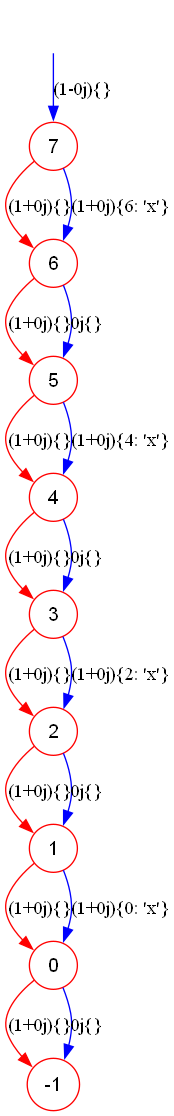

In [14]:
n=4
m=20

cir=gen_cir('Random_Clifford_T',n,m)
tdd=simulate(cir,True)
tdd_new,cir_head,cir_end=syn_tower(tdd)
# print(tdd.key_2_index)
tdd_new.show(False)

In [15]:
tdd_new2=None
for k in range(100):
    cir=gen_cir('Random_Clifford',n,m)
    tdd2=simulate(cir,False)
    # print(tdd2.node.key,tdd2.node_number())
    if tdd2.node_number()>9 or tdd2.node.key!=2*n-1:
        continue
    # print(1)
    tdd_new2,cir_head,cir_end=syn_tower(tdd2)
    if tdd_new2.node!=tdd_new.node or tdd_new2.map.level!=-1:
        print('Find one')
        break
tdd_new2.show(False)

11
22
[5, 4, 3, 2]
5 2 1 2
11
22
11
22
11
22
11
22
[7, 6, 1, 0]
[7, 3, 2, 0]
6 1 0 3
[7, 6, 3, 2]
7 2 0 2
11
22
11
22
[7, 6, 1, 0]
[6, 5, 1, 0]
[7, 5, 4, 0]
6 1 0 3
[7, 6, 5, 4]
7 4 0 1
11
22
[3, 2, 1, 0]
3 0 2 3
11
22
[7, 6, 5, 4, 3, 2]
7 4 0 1
[7, 6, 3, 2]
7 2 0 2
[5, 4, 3, 2]
5 2 1 2
11
22
[3, 2, 1, 0]
3 0 2 3
11
22
[7, 6, 1, 0]
7 0 0 3
11
22
[5, 4, 1, 0]
5 0 1 3
[3, 2, 1, 0]
3 0 2 3
11
22
11
22
11
22
[5, 4, 3, 2, 1, 0]
5 0 1 3
[5, 4, 3, 2]
5 2 1 2
11
22
11
22



KeyboardInterrupt



In [16]:
cir.draw()

┌───┐┌───┐┌───┐┌───┐     ┌───┐┌───┐     
q_0: ───────────────┤ X ├┤ X ├┤ Z ├┤ Z ├──■──┤ Y ├┤ X ├─────
               ┌───┐└─┬─┘└─┬─┘├───┤├───┤  │  └───┘├───┤     
q_1: ──────────┤ X ├──■────┼──┤ H ├┤ S ├──┼────■──┤ H ├─────
     ┌───┐     └─┬─┘       │  └───┘├───┤  │  ┌─┴─┐├───┤┌───┐
q_2: ┤ H ├───────┼─────────■────■──┤ Y ├──┼──┤ X ├┤ H ├┤ H ├
     ├───┤┌───┐  │  ┌───┐     ┌─┴─┐└───┘┌─┴─┐└───┘└───┘└───┘
q_3: ┤ X ├┤ H ├──■──┤ H ├─────┤ X ├─────┤ X ├───────────────
     └───┘└───┘     └───┘     └───┘     └───┘

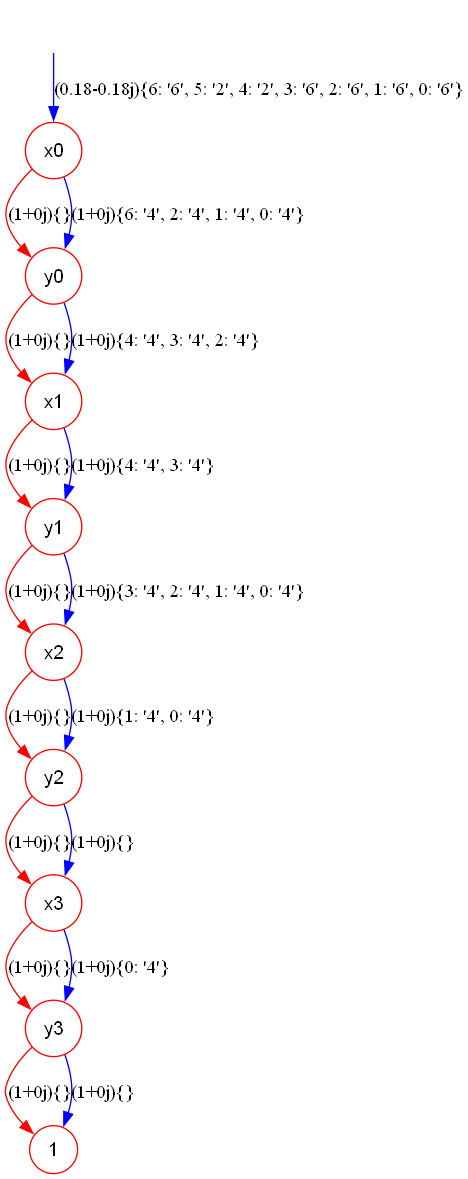

In [17]:
tdd2=simulate(cir,False)
tdd2.show()

[7, 6, 3, 2]
7 2 0 2
11
22


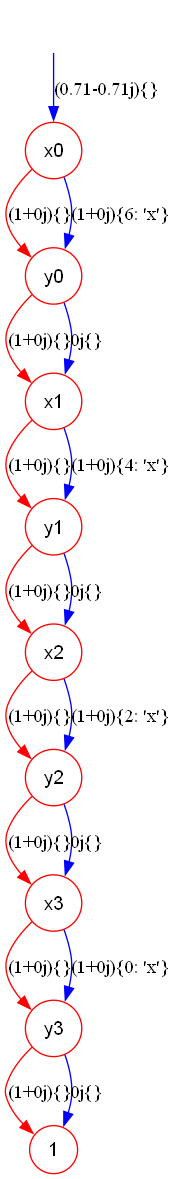

In [18]:
tdd_new,cir_head,cir_end=syn_tower(tdd2)
tdd_new.show()

[]


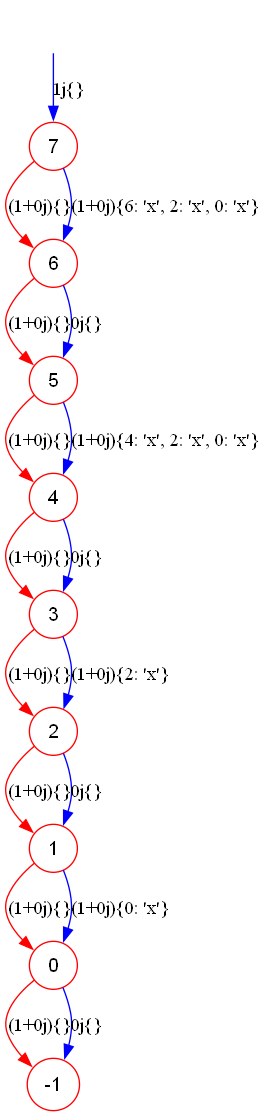

In [9]:
    n = int(tdd.key_2_index[0][1:])+1
    cir_head = QuantumCircuit(n)
    cir_end = QuantumCircuit(n)
    
    tdd_new = tdd2.self_copy()
    if tdd_new.node_number()>2*n+1:
        tdd_new = renormalize(tdd_new)

    tdd_new,cir_head,cir_end=eleminate_border(tdd_new)


    # tdd_new3 = tdd_new.self_copy()
    for k in range(n):
        tdd_new,cir_head3,cir_end3 = eliminate_top_matrix(tdd_new,k)
    tdd_new = renormalize(tdd_new)
    tdd_new2=tdd2.self_copy()
    
    while tdd_new!=tdd_new2:
        tdd_new2 = tdd_new.self_copy()
    
        tdd_new,cir_head2,cir_end2=eleminate_border(tdd_new)

        for k in range(n):
            tdd_new,cir_head3,cir_end3 = eliminate_top_matrix(tdd_new,k)
        tdd_new = renormalize(tdd_new)
        
    cycles,G = find_depend_cycle(tdd_new)
    print(cycles)
    # while cycles:
    #     tdd_new,cir_head2,cir_end2 = eliminate_entangel_through_swap2(tdd_new,cycles,G)
    #     cycles,G = find_depend_cycle(tdd_new)
    tdd_new.show(False)

[]


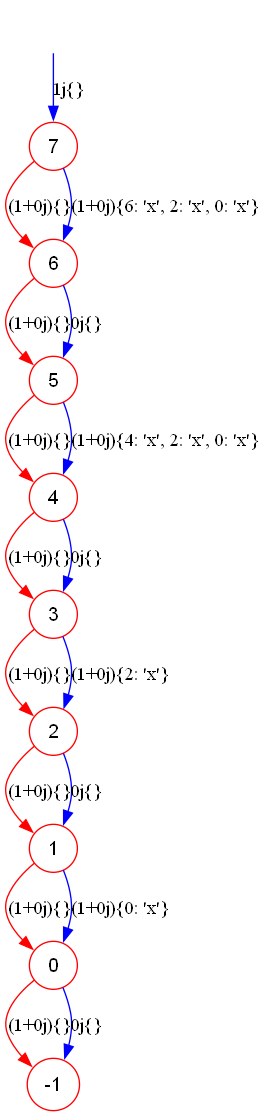

In [10]:
    while cycles:
        tdd_new,cir_head2,cir_end2 = eliminate_entangel_through_swap2(tdd_new,cycles,G)
        cycles,G = find_depend_cycle(tdd_new)
    print(cycles)
    tdd_new.show(False)

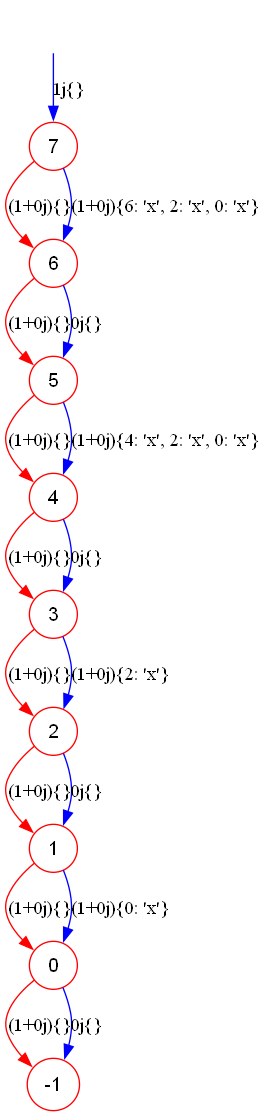

In [11]:
    tdd_new3 = tdd_new.self_copy()
    for k in range(n):
        tdd_new3,cir_head3,cir_end3 = eliminate_top_matrix(tdd_new3,k)
    tdd_new3 = renormalize(tdd_new3)
    
    tdd_new3.show(False)

In [12]:
    tdd_new4=tdd_new3.self_copy()
    for k in range(n-1):
        tdd_new4,cir_head4,cir_end4=eliminate_top_partial_control2(tdd_new4,k)

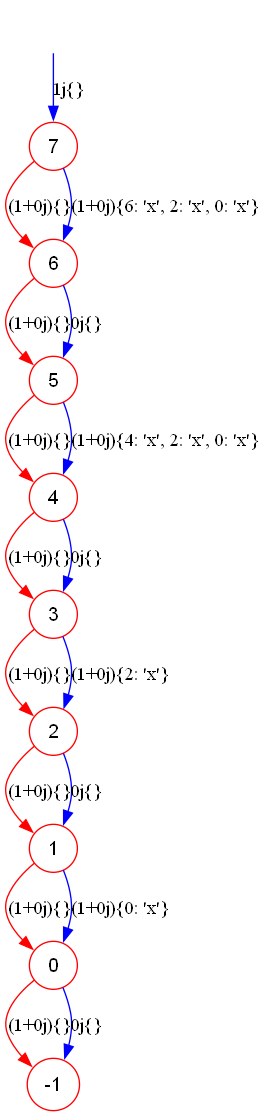

In [13]:
tdd_new3 = renormalize(tdd_new3)
tdd_new3.show(False)